Data Processing

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Mount drive to import data file
from google.colab import drive
drive.mount('/content/drive')

# Ethan drive mount
# drive.mount('/content/gdrive')

Mounted at /content/drive


In [4]:
# Importing data
# retrieved from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download
import torchvision.transforms as transforms
import torchvision.datasets as d
from torch.utils.data import DataLoader, Dataset, Subset

# https://pytorch.org/vision/0.9/transforms.html
# https://pytorch.org/vision/main/generated/torchvision.tv_tensors.Image.html
# https://discuss.pytorch.org/t/resizing-dataset/75620/4

# transform images to rescale, resize, normalize
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shortest side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load your dataset with the defined transformations
# my path is /content/drive/My Drive/Colab Notebooks/APS360/Data NvsBvsV & /content/drive/My Drive/Colab Notebooks/APS360/Data Augmentation
# dear teammates will have to make their own path with the data that's been shared
# graces path '/content/drive/My Drive/Data Augmentation'
# ETHAN JAN WANG JAN BOYAN ETHAN OH BOY OH BOY path "/content/drive/MyDrive/Uni/Year 2/Sem 2/APS360/Data NvsP"
# Renzo path  "/content/gdrive/MyDrive/Colab Notebooks/APS360/Data NvsP"
dataset = d.ImageFolder("/content/drive/My Drive/Colab Notebooks/APS360/Data NvsBvsV", transform=transform)
dataset_aug = d.ImageFolder("/content/drive/My Drive/Colab Notebooks/APS360/Data Augmentation", transform=transform)

In [5]:
# pick 80/10/10 split, remove 90% of the dataset to reduce size of dataset due to computational cost temporarily
# Rebalanced dataset to 1440 images per class
torch.manual_seed(1000)
print(f'Total images: {len(dataset)}')
extra, train, val, test = torch.utils.data.random_split(dataset, [0.90, 0.08, 0.01, 0.01])
print(f'Training images: {len(train)}')
print(f'Validation images: {len(val)}')
print(f'Test images: {len(test)}')

print("Data augmentation dataset")
print(f'Total images: {len(dataset_aug)}')
extra_aug, train_aug, val_aug, test_aug = torch.utils.data.random_split(dataset_aug, [0.90, 0.08, 0.01, 0.01])
print(f'Training images: {len(train_aug)}')
print(f'Validation images: {len(val_aug)}')
print(f'Test images: {len(test_aug)}')

Total images: 4330
Training images: 346
Validation images: 43
Test images: 43
Data augmentation dataset
Total images: 1566
Training images: 126
Validation images: 15
Test images: 15


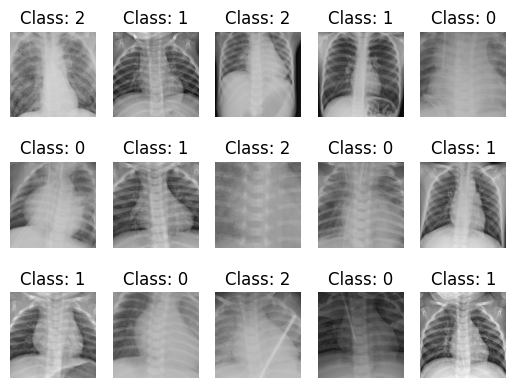

In [6]:
# Function to denormalize and convert tensor to numpy array
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor (C, H, W) to Numpy (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to the valid range [0, 1]
    plt.imshow(img)
    # plt.show()

# Visualize the first 15 images
k = 0
for img, label in train:
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    imshow(img)
    plt.title(f'Class: {label}')  # Set the label as xlabel

    k += 1
    if k > 14:
        break
plt.show()

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if isinstance(image, torch.Tensor):
          image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
def dataset_to_numpy(dataset):
    X, y = [], []

    for img, label in dataset:
        img = img.numpy().flatten()  # Convert to NumPy and flatten
        X.append(img)
        y.append(label)

    return np.array(X, dtype=np.float32), np.array(y)

# Convert training and test sets
x_train, y_train = dataset_to_numpy(train)
x_test, y_test = dataset_to_numpy(test)

Data Augmentation

In [9]:
# Imports
from diffusers import AutoencoderKL
from PIL import Image
from torchvision import transforms, datasets
import os
from torchvision.utils import save_image

In [ ]:
#I'm using a pretrained vae autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.eval()

vae_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
augmented_dir = "/content/drive/My Drive/augmented_data" #change your path
os.makedirs(augmented_dir, exist_ok=True)

In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, save_dir):
        self.dataset = dataset
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = vae_transform(image)

        with torch.no_grad():
            latents = vae.encode(image.unsqueeze(0)).latent_dist.sample() #compresses image to latent space + adds noise
            augmented_image = vae.decode(latents).sample.squeeze(0) #reconstructs new image

        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) #need to remove the vae tranformation
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        augmented_image = augmented_image * std + mean
        augmented_image = augmented_image.clamp(0, 1)

        save_path = os.path.join(self.save_dir, f"aug_{idx}.pt")
        torch.save((augmented_image, label), save_path)

        return augmented_image, label

In [ ]:
augmented_dataset = AugmentedDataset(test_aug, augmented_dir) #just doing it with test
augmented_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

In [ ]:
for i in range(len(augmented_dataset)):
    _, _ = augmented_dataset[i]  #discards returns, just save

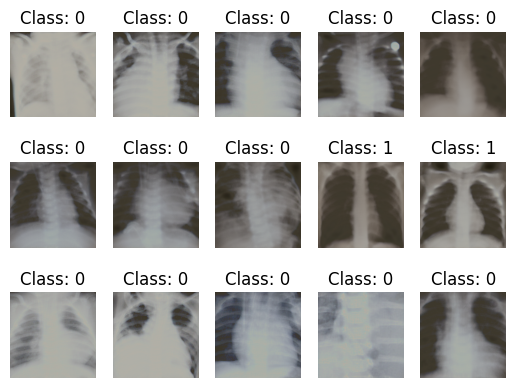

In [ ]:
#visualize 15 images
k = 0

for i in range(15):
    aug_img, label = torch.load(os.path.join(augmented_dir, f"aug_{i}.pt"))

    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(aug_img.permute(1, 2, 0))
    plt.title(f'Class: {label}')
    k += 1

plt.show()

Baseline Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [ ]:
#confirming class labels
print(np.unique(y_test))

To alter the SVM model to classify three classes instead of 2, we have the option of taking two approaches. The first is One-vs-One approach where a classifier is responsible for each possible pair of classes, while ignoring the others. During prediction, a majority vote is taken from each classifier to determine the output. The other approach is the One-vs-All approach where we train a single classifer for each class and compare it against all other classes (grouped as a whole, essentially a negative class). During prediction, each classifier outputs a likelihood score for their respective class and the highest score is selected. When the number of classes is smaller, OvO is more advantagoues, on the other hand OvR scales linearly and is better for larger class sizes. Since we only have 3 classes, we decided to go with the OvO approach.

In [ ]:
# https://scikit-learn.org/stable/modules/svm.html
svm_model = SVC(decision_function_shape='ovo')

svm_model.fit(x_train, y_train)

prediction = svm_model.predict(x_test)

# Output results
accuracy = svm_model.score(x_test, y_test)
print(f"Model accuracy {accuracy*100}\nModel error {(1-accuracy)*100}")

print(classification_report(y_test, prediction))

In [ ]:
# Plotting results
# Visualize hyperplane

# Reduce to 2D
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Re-train model on PCA-transformed data
svm_model_pca = SVC(decision_function_shape='ovo')
svm_model_pca.fit(x_train_pca, y_train)

# Predict and plot
import numpy as np
import matplotlib.pyplot as plt

h = 0.02
x_min, x_max = x_test_pca[:, 0].min() - 1, x_test_pca[:, 0].max() + 1
y_min, y_max = x_test_pca[:, 1].min() - 1, x_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.coolwarm)
plt.title("SVM Decision Boundary (PCA Projection, OvO)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
cm=confusion_matrix(y_train,prediction)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('SVM Confusion Matrix')
plt.show()

In [ ]:
# Step 1: Apply PCA to Reduce for Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train)
support_vectors_pca = pca.transform(svm_model.support_vectors_)  # Only transform support vectors

# Step 2: Create a Smaller Grid for Decision Boundary
x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),  # Reduce grid size from 100x100 to 50x50
                     np.linspace(y_min, y_max, 50))

# Step 3: Predict Directly on PCA-Reduced Grid (No Inverse Transform)
grid_points_pca = np.c_[xx.ravel(), yy.ravel()]
Z = svm_model.predict(pca.inverse_transform(grid_points_pca))  # Predict without large inverse transformation
Z = Z.reshape(xx.shape)

# Step 4: Plot Decision Boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

classes = np.unique(y_train)
colors = ["blue", "red"]  # or however many classes you have

for cls, col in zip(classes, colors):
    plt.scatter(X_train_pca[y_train == cls, 0],
                X_train_pca[y_train == cls, 1],
                c=col,
                alpha=0.5,
                edgecolors='w',
                label=f"Train Data (Class {cls})")

plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], edgecolors='black', facecolors='none', s=100, label="Support Vectors")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM Decision Boundary")
plt.legend()
plt.show()


Primary Model

In [ ]:
# model name function from lab 2 to help with data checkpoints and plotting
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# evaluate function from lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        """ corr = outputs != labels
        total_err += int(corr.sum())"""
        total_loss += loss.item()
        total_epoch += len(labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

# from tut 3
def get_accuracy(model, train=False):
    if train:
        data = train
    else:
        data = val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# train net function from lab 2
def train_net(net, batchsize, lr, epoch, train, val):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #Comvert data to tensors and load the batches
    traindataset=Dataset(train, transform=transform)
    valdataset=Dataset(val, transform=transform)
    trainloader=torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True)
    valloader=torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True)

    #set up error and loss array
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    #iterate through and train the data
    for epoch in range(epoch):
        total_train_samples=0
        i=0
        for image, label in trainloader:
            optimizer.zero_grad()
            output=net(image)
            loss=criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch]+=loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch] += (predicted != label).sum().item()
            total_train_samples+=len(label)
            i+=1
        #calculate error loss for each epoch
        train_loss[epoch]/=(i+1)
        train_error[epoch]/=total_train_samples
        #evaluate v=on validation for each epoch
        val_err[epoch], val_loss[epoch] = evaluate(net, valloader, criterion)
        print(f"Epoch {epoch+1}: Train Loss: {train_loss[epoch]}, Train Error: {train_error[epoch]}, Val Loss: {val_loss[epoch]}, Val Error: {val_err[epoch]}")
        #checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch)
        torch.save(net.state_dict(), model_path)
    #save the model to plot later
    epochs = np.arange(1, epoch + 1)
    a=np.savetxt("{}_train_err.csv".format(model_path), train_error)
    b=np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    c=np.savetxt("{}_val_err.csv".format(model_path), val_err)
    d=np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
#Convolutional Neural Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(32 * 53 * 53, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 3) # 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 53, 53)
        x = x.view(-1, 32 * 53 * 53)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Check if the model can overfit
small_train = Subset(train, range(10))
small_val = Subset(val, range(10))

net=Net()
train_net(net, 12, 0.01, 10, small_train, small_val)

In [ ]:
model_path = get_model_name("Net", batch_size=12, learning_rate=0.01, epoch=9)
plot_training_curve(model_path)

Hyperparameter Tuning

In [ ]:
#From lab 2 to help plot curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# Tune hyperparameters
# Model 1 - 2 convolutional layers, kernel size 5, batch 64, lr 0.01
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.name = "Net1"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(32 * 53 * 53, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 53, 53)
        x = x.view(-1, 32 * 53 * 53)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1=Net1()

train_net(net1, 64, 0.01, 30, train, val)

In [ ]:
model_path = get_model_name("Net1", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Model 2 - Decreased batch size and lr to 32 and 0.001 respectively
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.name = "Net2"
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2 = Net2()

train_net(net2, 32, 0.001, 30, train, val) #Decreased batch size and decreased learning rate

In [ ]:
model_path = get_model_name("Net2", batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Final model for first configuration. decreased batch increased lr
class NetF1(nn.Module):
    def __init__(self):
        super(NetF1, self).__init__()
        self.name = "NetF1"
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 53 * 53, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

netf1 = NetF1()

train_net(netf1, 46, 0.01, 30, train, val)

In [ ]:
model_path = get_model_name("NetF1", batch_size=46, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)


In [ ]:
# Model 3
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.name = "Net3"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net3=Net3()

train_net(net3, 64, 0.01, 30, train, val)

In [ ]:
model_path = get_model_name("Net3", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Model 4
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.name = "Net4"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net4=Net4()

train_net(net4, 54, 0.01, 30, train, val)

In [ ]:
model_path = get_model_name("Net4", batch_size=56, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Final model for second configuration: Increased learning rate to 0.015

In [ ]:
class NetF2(nn.Module):
    def __init__(self):
        super(NetF2, self).__init__()
        self.name = "NetF2"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

netf2=NetF2()

train_net(netf2, 54, 0.015, 30, train, val)

In [ ]:
model_path = get_model_name("NetF2", batch_size=54, learning_rate=0.015, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Overfitting
small_train = Subset(train, range(10))
small_val = Subset(val, range(10))

net_over = NetF2()
train_net(net_over, 12, 0.01, 30, small_train, small_val)

In [ ]:
model_path = get_model_name("NetF2", batch_size=12, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.name = "Net5"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 356)
        self.fc3 = nn.Linear(356, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net5=Net5()

train_net(net5, 56, 0.01, 30, train, val)

In [ ]:
class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        self.name = "Net6"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 356)
        self.fc3 = nn.Linear(356, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net6=Net6()

train_net(net6, 64, 0.01, 30, train, val)

model_path = get_model_name("Net6", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
# Final model for configuration 3 - Increased learning rate

class NetF3(nn.Module):
    def __init__(self):
        super(NetF3, self).__init__()
        self.name = "NetF3"
        self.conv1 = nn.Conv2d(3, 16, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(16, 32, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(32, 56, 5)  # in_channels, out_channels, kernel_size
        self.fc1 = nn.Linear(56 * 24 * 24, 512)  # Adjust the input size based on the output of conv layers
        self.fc2 = nn.Linear(512, 356)
        self.fc3 = nn.Linear(356, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 110, 110)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 56 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

netf3=NetF3()

train_net(netf3, 64, 0.0175, 30, train, val)


In [ ]:
model_path = get_model_name("NetF3", batch_size=64, learning_rate=0.0175, epoch=29)
plot_training_curve(model_path)

TESTING FOR ACCURACY

In [ ]:
import torch
from sklearn.metrics import confusion_matrix

def evaluate(net, loader, criterion):
    """ Evaluate the network on a dataset (e.g., test or validation set).

    Args:
        net: PyTorch neural network object (e.g., NetF2 with 2-class output)
        loader: PyTorch DataLoader for the dataset (e.g., testloader)
        criterion: Instantiated loss function (e.g., nn.CrossEntropyLoss())
    Returns:
        err: Average classification error over the dataset
        loss: Average loss over the dataset
        conf_matrix: Confusion matrix (2x2 for binary classification)
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    all_labels = []
    all_preds = []

    # Switch to evaluation mode (disables dropout, batch norm updates)
    net.eval()
    with torch.no_grad():  # Disable gradient computation for efficiency
        for i, data in enumerate(loader, 0):
            inputs, labels = data  # inputs: [batch_size, 3, 224, 224], labels: [batch_size] (integers 0 or 1)
            outputs = net(inputs)  # [batch_size, 2], raw logits for 2 classes
            loss = criterion(outputs, labels)  # Compute loss (expects integer labels)
            _, predicted = torch.max(outputs, 1)  # Predicted class indices (0 or 1)

            # Accumulate error and loss
            total_err += (predicted != labels).sum().item()
            total_loss += loss.item()
            total_epoch += labels.size(0)

            # Collect labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate averages
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)  # i+1 is the number of batches

    # Compute 2x2 confusion matrix (classes: 0=negative, 1=positive)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1])

    # Switch back to training mode
    net.train()

    return err, loss, conf_matrix


In [ ]:
testloader = torch.utils.data.DataLoader(test, batch_size=54, shuffle=True)

err, loss, conf_matrix = evaluate(netf2, testloader, nn.CrossEntropyLoss())
print(f"Confusion Matrix:\n{conf_matrix}")

In [ ]:
import numpy as np

# Print the confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the confusion matrix
# [[TN, FP],
#  [FN, TP]]
conf_matrix = np.array([[11, 3],  # First row: TN=11, FP=3
                        [8, 8]])  # Second row: FN=8, TP=8

# Extract values from the confusion matrix
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives (Type I errors)
FN = conf_matrix[1, 0]  # False Negatives (Type II errors)
TP = conf_matrix[1, 1]  # True Positives

# Calculate total samples
total_samples = TN + FP + FN + TP

# Calculate Type I and Type II error rates
type_1_error = FP / (FP + TN)  # False Positive Rate (Type I error)
type_2_error = FN / (FN + TP)  # False Negative Rate (Type II error)

# Calculate accuracy for reference
accuracy = (TN + TP) / total_samples

# Print error rates
print(f"Type I Error (False Positive Rate): {type_1_error:.4f}")
print(f"Type II Error (False Negative Rate): {type_2_error:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
